In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
sns.set(rc = {'figure.figsize':(15, 7)})
sns.set_style('white')
pd.set_option('display.max_columns', 500)

# ML

In [3]:
features = pd.read_csv('./data/features_dummified_214col.csv') # 2580 x 221
target = pd.read_csv('./data/Ames_Housing_Price_Data.csv')['SalePrice']

features2 = pd.read_csv('./data/features_dummified_376col.csv') # 2558 x 377
target2 = pd.read_csv('./data/target_376col.csv')['SalePrice']

###### Time Series Analysis

In [2]:
housing = pd.read_csv('./data/Ames_Housing_Price_Data.csv', index_col=0)

In [24]:
# for i in df2['Neighborhood'].unique():
#     print(df2[df2['Neighborhood'] == i])

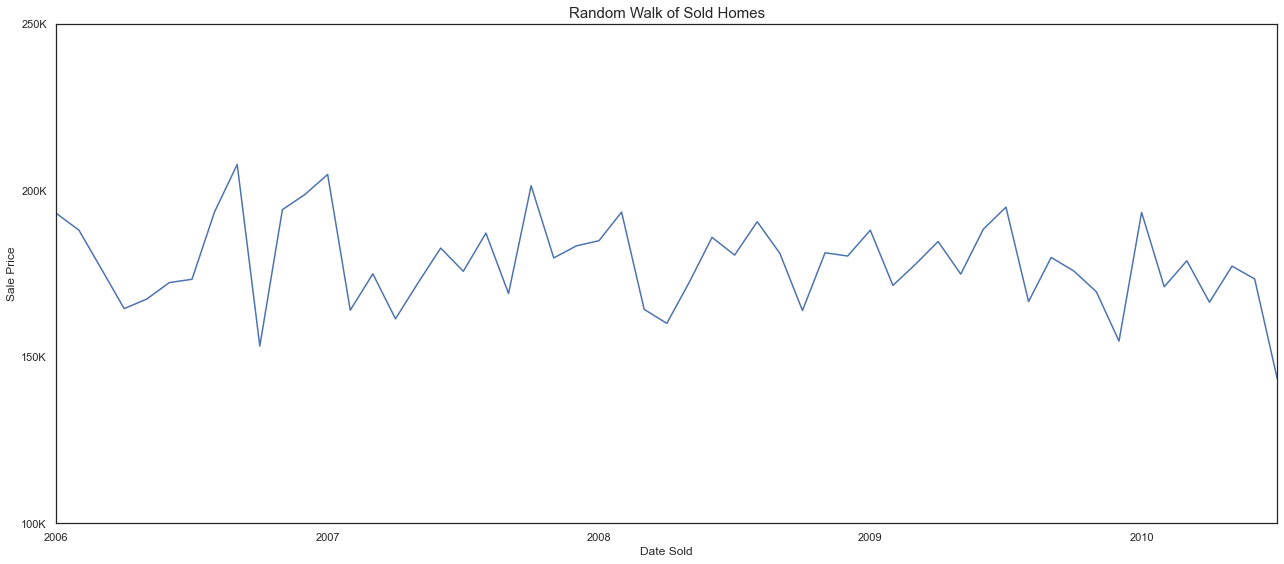

In [113]:
DateSold = pd.to_datetime(housing['YrSold'].astype(str) + '-' + 
                        housing['MoSold'].astype(str) + '-1').rename('DateSold')

df = housing[['SalePrice']].set_index(DateSold).groupby('DateSold').mean()
fig = df.plot(legend=False)
fig.set(xlabel='Date Sold',
        ylabel='Sale Price',
        xticks=['2006-01', '2007-01', '2008-01', '2009-01', '2010-01'],
        xticklabels=list(range(2006, 2011)),
        yticks=[1e5, 1.5e5, 2e5, 2.5e5],
        yticklabels=['100K', '150K', '200K', '250K'])
plt.title('Random Walk of Sold Homes', fontsize = 15)
plt.tight_layout()
plt.savefig('./visualizations/EDA - Timeseries DateSold, Lineplot.png', dpi = 1000)
plt.show()

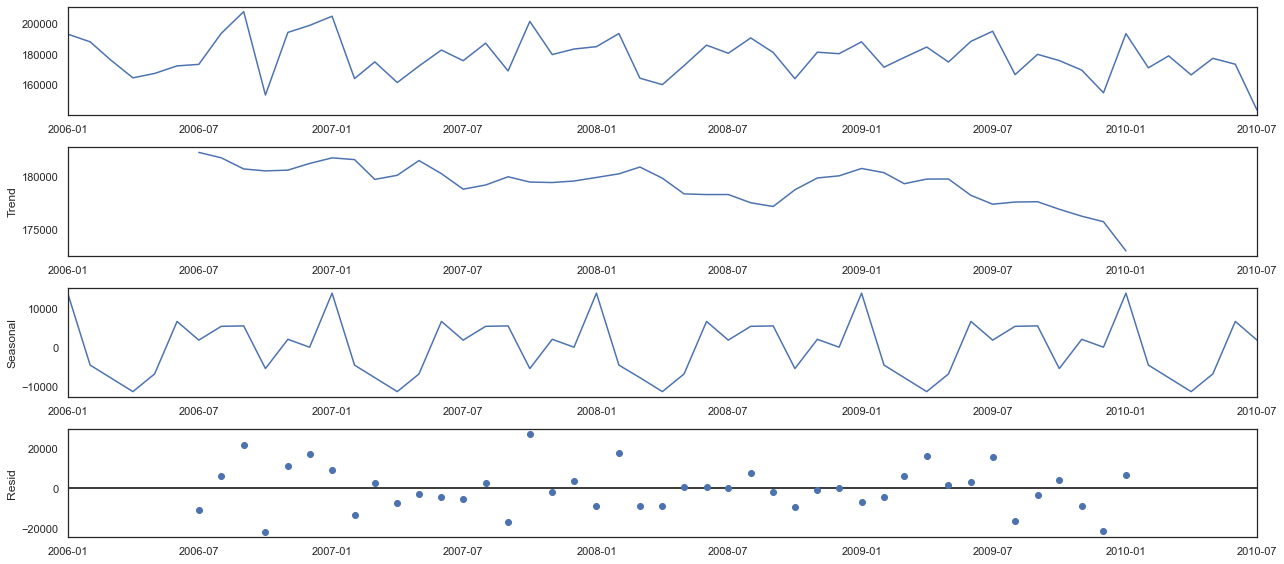

In [39]:
from pylab import rcParams
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

In [238]:
import itertools
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 11) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 11)
SARIMAX: (0, 0, 1) x (0, 0, 2, 11)
SARIMAX: (0, 0, 2) x (0, 0, 3, 11)
SARIMAX: (0, 0, 2) x (0, 1, 0, 11)


In [ ]:
results = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,
                                            trend_offset=2)
            result = mod.fit(disp=False)
            results.append([param, param_seasonal, result.aic])
            
        except:
            continue

In [66]:
# lets find the best parameters with the lowest AIC score and lowest MSE

optimal_sarima = 1e6
pdq = []
seasonal_pdq = []

for arima, sarima, aic in results:
    if aic < optimal_sarima:
        optimal_sarima = aic
        pdq = arima
        seasonal_pdq = sarima
    else:
        continue
        
print(f'arima: {pdq}, sarima: {seasonal_pdq}, AIC: {optimal_sarima}')

arima: (1, 1, 1), sarima: (1, 1, 0, 12), AIC: 647.9074875449958


In [225]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
result = mod.fit(disp=False)
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5887      0.528     -1.116      0.265      -1.623       0.445
ma.L1          0.0422      0.597      0.071      0.944      -1.128       1.212
ar.S.L12      -0.5997      0.361     -1.662      0.097      -1.307       0.108
sigma2      3.357e+08   9.01e-10   3.72e+17      0.000    3.36e+08    3.36e+08


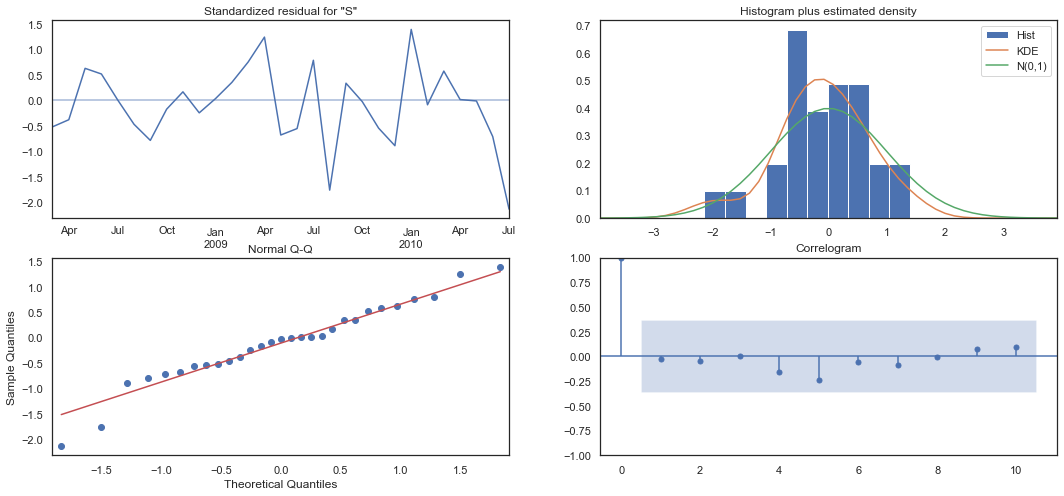

In [226]:
result.plot_diagnostics()
plt.show()

In [227]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
result = mod.fit(disp=False)
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5887      0.528     -1.116      0.265      -1.623       0.445
ma.L1          0.0422      0.597      0.071      0.944      -1.128       1.212
ar.S.L12      -0.5997      0.361     -1.662      0.097      -1.307       0.108
sigma2      3.357e+08   9.01e-10   3.72e+17      0.000    3.36e+08    3.36e+08


In [198]:
result = mod.fit(disp=False, return_params=True)

In [222]:
adf = sm.tsa.adfuller(df, regression='ct')
print(f'adf test: {adf[0]}, p-value: {adf[1]}')

adf test: -6.948276068898889, p-value: 1.8493823638383215e-08


In [205]:
pred = result.get_prediction(start=pd.to_datetime('2009-06-01'), dynamic=True)
pred.se_mean

2009-06-01    14670.227611
2009-07-01    18450.832963
2009-08-01    20992.503639
2009-09-01    23089.349976
2009-10-01    24959.513307
2009-11-01    26682.840608
2009-12-01    28296.285435
2010-01-01    29820.919557
2010-02-01    31270.776553
2010-03-01    32656.154710
2010-04-01    33985.049786
2010-05-01    35263.883647
2010-06-01    36497.930559
2010-07-01    37691.593664
Freq: MS, Name: var_pred_mean, dtype: float64

In [209]:
pred.predicted_mean - 

2009-06-01    176213.768550
2009-07-01    185917.071968
2009-08-01    191975.915758
2009-09-01    171598.245382
2009-10-01    179578.066151
2009-11-01    176577.357208
2009-12-01    171465.778765
2010-01-01    159337.830642
2010-02-01    186864.813496
2010-03-01    172573.439739
2010-04-01    177872.375439
2010-05-01    168793.605561
2010-06-01    176026.045389
2010-07-01    173596.262145
Freq: MS, Name: predicted_mean, dtype: float64

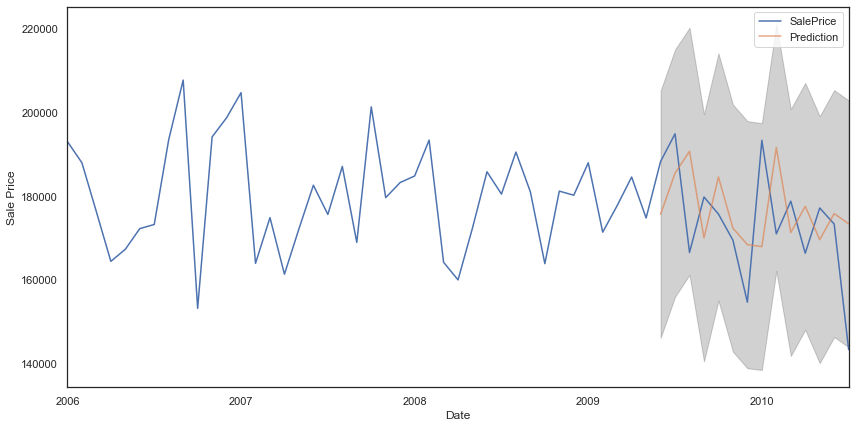

arima: (1, 1, 1), sarima: (1, 1, 1, 12), aic: 2142.850673822575, rmse = 17805.812761652465


In [237]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
result = mod.fit(disp=False)

pred = result.get_prediction(start=pd.to_datetime('2009-06-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df.plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 7))
mse = ((df['2010-01-01':].squeeze() - pred.predicted_mean) ** 2).mean()
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()
plt.show()
print(f'arima: {arima}, sarima: {sarima}, aic: {aic}, rmse = {mse ** 0.5}')

In [70]:
import math
for arima, sarima, aic in results:
    
    for 
    
    mod = sm.tsa.statespace.SARIMAX(df,
                                order=arima,
                                seasonal_order=sarima,
                                enforce_stationarity=True,
                                enforce_invertibility=True)
    result = mod.fit(disp=False)

    pred = result.get_prediction(start=pd.to_datetime('2009-01-01'), dynamic=False)
    pred_ci = pred.conf_int()
    ax = df.plot(label='Observed')
    pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 7))
    
    mse = ((df['2010-01-01':].squeeze() - pred.predicted_mean) ** 2).mean()
    
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Sale Price')

    plt.legend()
    plt.show()
    print(f'arima: {arima}, sarima: {sarima}, aic: {aic}, mse = {mse}')

# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

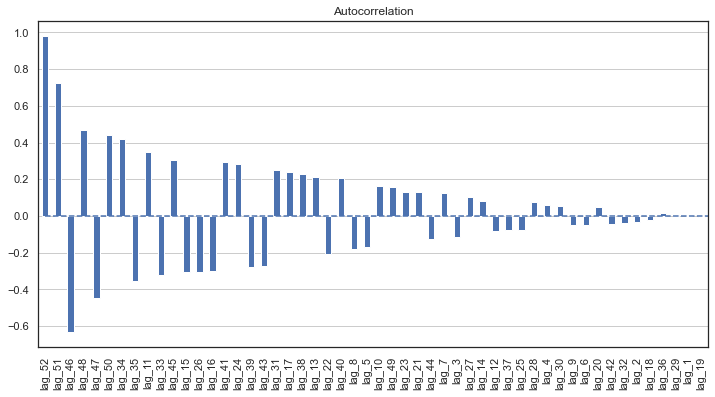

In [114]:

# auto_cor = sales.groupby("Date")["Weekly_Sales"].sum()
# auto_cor = pd.DataFrame(auto_cor)
# auto_cor.columns = ["y"]

df2 = df.copy()
# Adding the lag of the target variable from 1 steps back up to 52 (due to a seasonality at the end of the year)
for i in range(1, 53):
    df2["lag_{}".format(i)] = df2.SalePrice.shift(i)

# Compute autocorrelation of the series and its lags
lag_corr = df2.corr()
lag_corr = lag_corr.iloc[1:,0]
lag_corr.columns = ["corr"]
order = lag_corr.abs().sort_values(ascending = False)
lag_corr = lag_corr[order.index]

# Plot the Autocorrelation
plt.figure(figsize=(12, 6))
lag_corr.plot(kind='bar')
plt.grid(True, axis='y')
plt.title("Autocorrelation")
plt.hlines(y=0, xmin=0, xmax=len(lag_corr), linestyles='dashed')

In [107]:
import pmdarima as pm

In [122]:
stepwise_model = pm.auto_arima(df.iloc[:].values, start_p=1, start_q=1,
                               max_p=20, max_q=20, m=52,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=inf, Time=54.90 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=46.491, Time=2.17 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=35.91 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=20.54 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=5.26 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=4.21 sec
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=46.911, Time=26.37 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=47.931, Time=1.18 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=48.884, Time=0.94 sec
 ARIMA(1,1,1)(0,1,0)[52]             : AIC=48.086, Time=15.16 sec
 ARIMA(0,1,0)(0,1,0)[52] intercept   : AIC=46.411, Time=0.44 sec
 ARIMA(0,1,0)(1,1,0)[52] intercept   : AIC=48.145, Time=7.01 sec
 ARIMA(0,1,0)(0,1,1)[52] intercept   : AIC=inf, Time=6.79 sec
 ARIMA(0,1,0)(1,1,1)[52] intercept   : AIC=49.778, Time=6.70 sec
 ARIMA(1,1,0)(0,1,0)[52] intercept   : AIC=49.931, Time=1.06

In [145]:
train, test = train_test_split(df, test_size=0.3, random_state=44)